
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Course Project <br>
</div>


---



ARMAN ARIANPOUR 401170072



KOUSHA MOEINI 401100228



PARSA GHOLAMI 401100477

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from numba import njit
import torch
import random

## Section 1: Finding the Objects

In this part, we are going to implement functions to find and indicate samples of `template.png` in `input.jpg`. We will use correlation based methods to achieve this. You can see chapter 13.3 of the course reference for more information on how to do this. As a brief summary, there are four methods you can consider:


1.   **Cross Correlation**
2.   **Zero-mean Cross Correlation**
3.  **Sum of Squared Differences (SSD)**
4.  **Normalized Cross Correlation**

You are free to use any of the above methods (or a combination of them) you prefer (it is recommended to use Normalized Cross Correlation).



In [2]:
##edit template
def crop_border(image_path):
    img = Image.open(image_path)
    width, height = img.size
    cropped_img = img.crop((
        80,           # left
        80,           # top
        width - 90,   # right
        height - 80   # bottom
    ))
    return cropped_img

In [3]:
def find_template(img_gray: np.ndarray, template_gray: np.ndarray, scales: list):
    all_detections = []
    (tH, tW) = template_gray.shape[:2]

    for scale in scales:
        resized_template = cv2.resize(template_gray, (int(tW * scale), int(tH * scale)))

        if resized_template.shape[0] > img_gray.shape[0] or resized_template.shape[1] > img_gray.shape[1] or \
           resized_template.shape[0] == 0 or resized_template.shape[1] == 0:
            continue

        result = cv2.matchTemplate(img_gray, resized_template, cv2.TM_CCOEFF_NORMED)

        loc = np.where(result >= 0.45)
        for pt in zip(*loc[::-1]):
            score = result[pt[1], pt[0]]
            all_detections.append((score, (pt[0], pt[1], resized_template.shape[1], resized_template.shape[0])))

    return all_detections

Next function should draw a rectangle around the matches. Input is a masked image which is generated by the above function, indicating the matches.

In [85]:
def draw_bars(img: np.ndarray, detections: list, final_threshold: float = 0.5, fill: bool = False):
    boxes = []
    confidences = []
    expand = 100
    for (score, (x, y, w, h)) in detections:
        if score >= final_threshold:
            boxes.append([x, y, w, h])
            confidences.append(float(score))

    if len(boxes) > 0:
        rects, weights = cv2.groupRectangles(boxes, groupThreshold=1, eps=0.15)
    else:
        rects = []

    img_with_bars = img.copy()
    if len(rects) > 0:
        for (x, y, w_rect, h_rect) in rects:
            x_exp = max(x - int(0.90 * expand), 0)
            y_exp = max(y - int(1.30 * expand), 0)
            w_exp = w_rect + int(2 * 0.70 * expand)
            h_exp = h_rect + int(2 * 0.70 * expand)

            if fill:
                cv2.rectangle(img_with_bars, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (255, 255, 255), thickness=-1)
            else:
                cv2.rectangle(img_with_bars, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 0, 255), thickness=3)

    return img_with_bars


Now execute above functions for `input.jpg` and find matches for `temple.png`. Indicate the matches by drawing a rectangle around them and save the resulting image as `output1.jpg`. Your score for this part depends on the number of correct and incorrect matches.

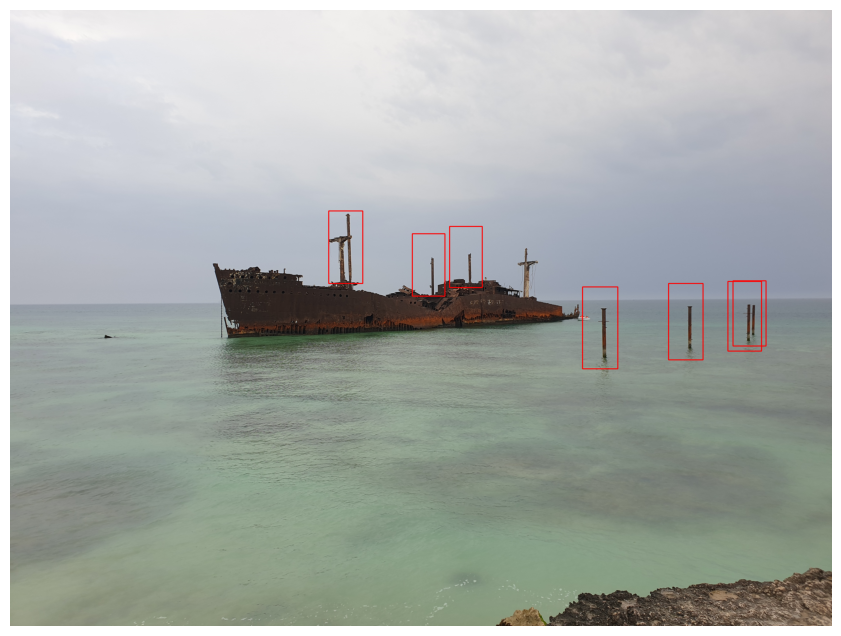

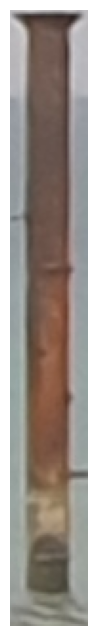

In [ ]:
img = cv2.imread('input\\input.jpg')
template = np.array(crop_border('input\\template.png'))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

scales = np.linspace(0.4, 1.0, 10)

all_detections = find_template(img_gray, template_gray, scales)

final_threshold = 0.60
output_image = draw_bars(img.copy(), all_detections, final_threshold=final_threshold)
cv2.imwrite('output\\output1.jpg', output_image)
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.figure(figsize=(12, 8))
plt.imshow(template)
plt.axis('off')
plt.show()

## Section 2: Image Completion

We will study and implement two methods for image completion.

### Method 1: Texture Synthesis

One way to complete a removed part of an image is to try regenerating the texture of its near pixels to cover it using texture synthesis. Texture synthesis is the process of constructing a large digital image from a small digital sample image by taking advantage of its structural content.

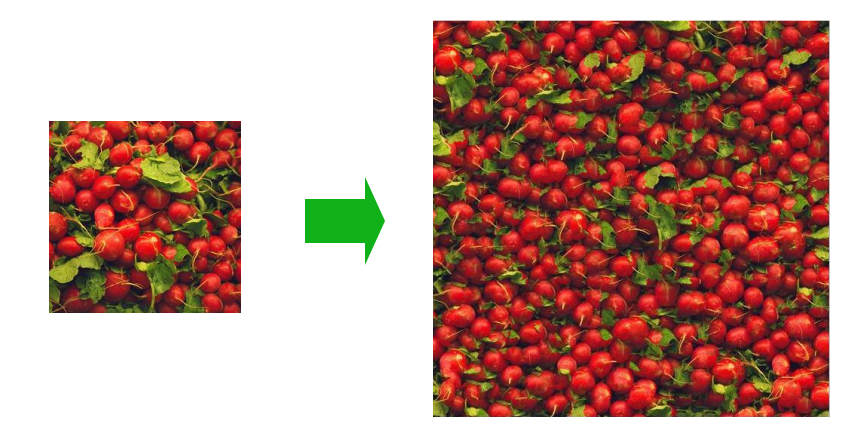

The method we are going to implement is based on the following paper:

 https://people.eecs.berkeley.edu/~efros/research/quilting/quilting.pdf

Complete the following function to apply texture synthesis to generate a larger image (with shape `result_shape`) with the given texture. `patch_size` indicated the size of the patch covered in each iteration. `overlap` is an integer indicating the number of overlaping pixels between any two patches.

**Note:** To avoid complicating this function, you may need to implement other helper functions and use them. implement them in the next cell.


In [6]:
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU Available: True
GPU Name: Tesla T4


In [7]:
@torch.no_grad()
def find_best_patch_sampled(texture, patch_size, overlap, above_patch=None, left_patch=None, n_candidates=500):
    C, H, W = texture.shape
    max_y = H - patch_size
    max_x = W - patch_size

    ys = torch.randint(0, max_y + 1, (n_candidates,), device=texture.device)
    xs = torch.randint(0, max_x + 1, (n_candidates,), device=texture.device)

    min_error = float('inf')
    best_y, best_x = 0, 0

    for i in range(n_candidates):
        y, x = ys[i].item(), xs[i].item()
        patch = texture[:, y:y+patch_size, x:x+patch_size]

        error = 0.0
        if above_patch is not None:
            diff = patch[:, :overlap, :] - above_patch[:, -overlap:, :]
            error += torch.mean(diff**2).item()
        if left_patch is not None:
            diff = patch[:, :, :overlap] - left_patch[:, :, -overlap:]
            error += torch.mean(diff**2).item()

        if error < min_error:
            min_error = error
            best_y, best_x = y, x

    return best_y, best_x


@torch.no_grad()
def minimum_error_boundary_cut(error_surface, is_vertical=True):
    h, w = error_surface.shape
    E = torch.zeros((h, w), device=error_surface.device)
    E[0, :] = error_surface[0, :]

    parent = torch.zeros((h, w), dtype=torch.int32, device=error_surface.device)

    for i in range(1, h):
        for j in range(w):
            candidates = []
            idxs = []
            for dj in [-2, -1, 0, 1, 2]:
                jj = j + dj
                if 0 <= jj < w:
                    candidates.append(E[i-1, jj])
                    idxs.append(jj)
            min_idx = torch.argmin(torch.stack(candidates))
            parent[i, j] = idxs[min_idx]
            E[i, j] = error_surface[i, j] + candidates[min_idx] * 0.8

    path = []
    j = torch.argmin(E[-1, :]).item()
    for i in range(h-1, -1, -1):
        path.append((i, j))
        j = parent[i, j].item()

    path.reverse()
    return path

In [8]:
@torch.no_grad()
def apply_texture_synthesis(texture_np, result_shape, patch_size=None, overlap=None, n_candidates=500):
    texture = torch.from_numpy(texture_np.transpose(2, 0, 1)).float().to(device)
    out_h, out_w = result_shape
    C, H, W = texture.shape

    if patch_size is None:
        patch_size = int(min(H, W) * 0.3)
    if overlap is None:
        overlap = int(patch_size * 0.2)

    step = patch_size - overlap
    y_steps = (out_h + step - 1) // step
    x_steps = (out_w + step - 1) // step

    result = torch.zeros((3, out_h, out_w), device=device)

    with tqdm(total=y_steps * x_steps, desc="Synthesizing", unit="patch") as pbar:
        for y_idx in range(y_steps):
            y = min(y_idx * step, out_h - patch_size)
            for x_idx in range(x_steps):
                x = min(x_idx * step, out_w - patch_size)

                above_patch = result[:, y - overlap:y, x:x + patch_size] if y > 0 else None
                left_patch = result[:, y:y + patch_size, x - overlap:x] if x > 0 else None

                by, bx = find_best_patch_sampled(texture, patch_size, overlap, above_patch, left_patch, n_candidates)
                patch = texture[:, by:by + patch_size, bx:bx + patch_size]

                blended_patch = patch.clone()

                if y > 0:
                    error_surface_y = torch.mean((patch[:, :overlap, :] - above_patch[:, -overlap:, :]) ** 2, dim=0)
                    path_y = minimum_error_boundary_cut(error_surface_y, is_vertical=True)
                    mask_y = torch.ones((patch_size, patch_size), device=patch.device)
                    for i, j in path_y:
                        mask_y[:i + 1, j:] = 0

                if x > 0:
                    error_surface_x = torch.mean((patch[:, :, :overlap] - left_patch[:, :, -overlap:]) ** 2, dim=0)
                    path_x = minimum_error_boundary_cut(error_surface_x.T, is_vertical=True)
                    mask_x = torch.ones((patch_size, patch_size), device=patch.device)
                    for j, i in path_x:
                        mask_x[i:, :j + 1] = 0

                if y > 0 and x > 0:
                    final_mask = torch.minimum(mask_y, mask_x)
                elif y > 0:
                    final_mask = mask_y
                elif x > 0:
                    final_mask = mask_x
                else:
                    final_mask = torch.ones((patch_size, patch_size), device=patch.device)

                alpha = final_mask.unsqueeze(0)
                blended_patch = alpha * patch + (1 - alpha) * result[:, y:y + patch_size, x:x + patch_size]

                result[:, y:y + patch_size, x:x + patch_size] = blended_patch
                pbar.update(1)

    return result.permute(1, 2, 0).cpu().numpy()


Apply this function on `texture1.jpg`, `texture2.jpg` and `texture3.jpg` and save the results as `output-synthesis1.jpg`, `output-synthesis2.jpg` and `output-synthesis3.jpg`, respectively. Dimension of the results should be $2400 \times 2400$. You can choose `patch_size` and `overlap` properly to get the best result. Your score on this part depends on the quality of the results.

Synthesizing:   0%|          | 0/225 [00:00<?, ?patch/s]

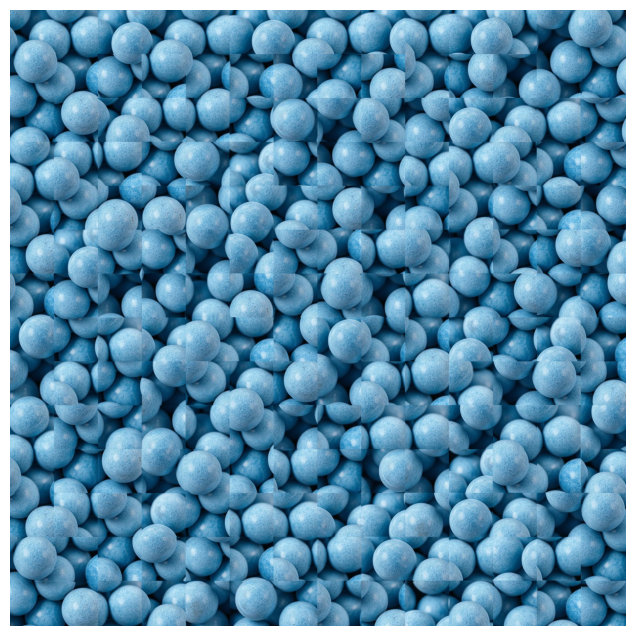

Synthesizing:   0%|          | 0/2500 [00:00<?, ?patch/s]

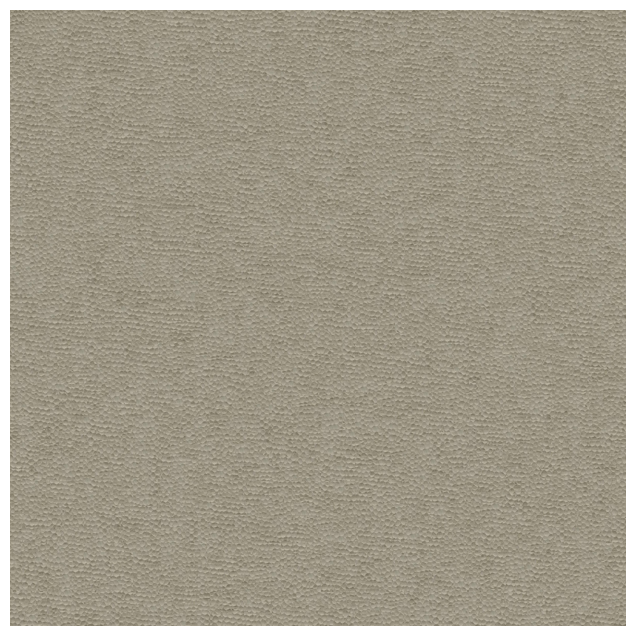

Synthesizing:   0%|          | 0/2500 [00:00<?, ?patch/s]

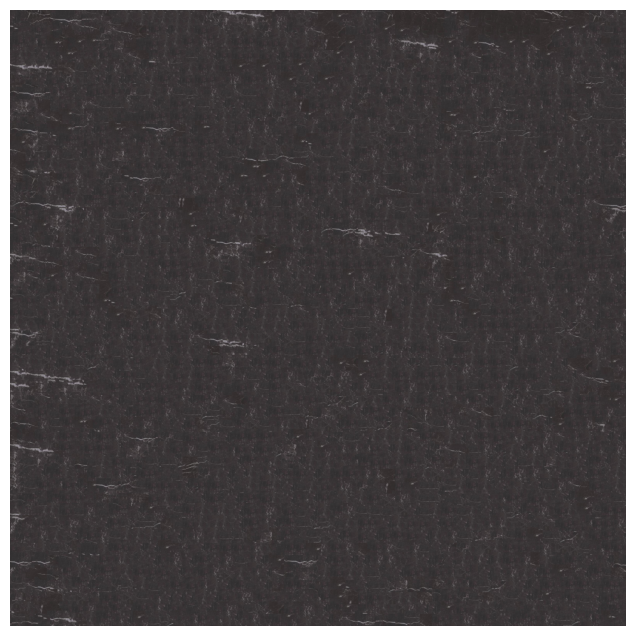

In [ ]:
textures = [
    ('input\\texture1.jpg', 'output\\output-synthesis1.jpg', 172, 1,10000),
    ('input\\texture2.jpg', 'output\\output-synthesis2.jpg', 60, 12,2000),
    ('input\\texture3.jpg', 'output\\output-synthesis3.jpg', 60, 12,2000),
]

result_shape = (2400, 2400)
for input_file, output_file, patch_size, overlap, n_candidates in textures:
    texture = cv2.imread(input_file)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
    result = apply_texture_synthesis(texture, result_shape, patch_size, overlap, n_candidates=n_candidates)
    result = np.clip(result, 0, 255).astype(np.uint8)
    cv2.imwrite(output_file, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(8, 8))
    plt.imshow(result)
    plt.axis('off')
    plt.show()

### Method 2: Patch Match

**Patch Match** is a method for image inpainting introduced in the following work:

Website: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/index.php

Paper: https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/patchmatch.pdf


Implement the following function to apply patch match on image `A` from image `B`:

In [9]:
def create_rectangular_hole(image, x, y, width, height):
    image_copy = image.copy()
    image_copy[y:y+height, x:x+width] = 255
    return image_copy
def _get_border_pixels(mask):
    borders = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))) - mask
    return np.argwhere(borders > 0)


def _extract_patch(image, mask, y, x, patch_size, height, width):
    half_patch = patch_size // 2
    y1, y2 = max(0, y - half_patch), min(height, y + half_patch + 1)
    x1, x2 = max(0, x - half_patch), min(width, x + half_patch + 1)

    patch = image[y1:y2, x1:x2]
    patch_mask = mask[y1:y2, x1:x2]
    return patch, patch_mask, (y1, y2, x1, x2)


def _find_best_match(image, inv_mask, patch, patch_mask, y, x, patch_size, search_window, height, width):
    half_patch = patch_size // 2
    best_match = None
    best_distance = float('inf')

    for _ in range(200):
        ry = random.randint(max(0, y - search_window), min(height - patch_size, y + search_window))
        rx = random.randint(max(0, x - search_window), min(width - patch_size, x + search_window))

        if inv_mask[ry + half_patch, rx + half_patch] == 0:
            continue

        dy1 = (patch.shape[0] // 2) - half_patch
        dy2 = dy1 + patch.shape[0]
        dx1 = (patch.shape[1] // 2) - half_patch
        dx2 = dx1 + patch.shape[1]

        ref_patch = image[ry + dy1 : ry + dy2, rx + dx1 : rx + dx2]

        if ref_patch.shape != patch.shape:
            continue

        valid_mask = (patch_mask != 255)[..., np.newaxis]
        distance = np.sum(((patch - ref_patch) * valid_mask) ** 2)

        if distance < best_distance:
            best_distance = distance
            best_match = ref_patch

    return best_match


def _apply_patch(filled, mask, best_match, patch, patch_mask, y1, y2, x1, x2):
    filled[y1:y2, x1:x2] = np.where(
        patch_mask[..., np.newaxis] == 255,
        best_match,
        patch
    )
    mask[y1:y2, x1:x2] = 0


In [10]:
def perform_patch_match(img, mask, patch_size=31, iterations=15, search_window=300):
    image = img.astype(np.float32)
    height, width = image.shape[:2]
    inv_mask = 255 - mask
    filled = image.copy()
    overall_progress = tqdm(total=iterations, desc='Overall Progress', position=0)

    for iter in range(iterations):
        border_pixels = _get_border_pixels(mask)
        random.shuffle(border_pixels)
        pixel_progress = tqdm(total=len(border_pixels), desc=f'Iteration {iter+1}', position=1, leave=False)

        for y, x in border_pixels:
            patch, patch_mask, (y1, y2, x1, x2) = _extract_patch(filled, mask, y, x, patch_size, height, width)

            if np.all(patch_mask == 255):
                pixel_progress.update(1)
                continue

            best_match = _find_best_match(
                filled, inv_mask, patch, patch_mask,
                y, x, patch_size, search_window, height, width
            )

            if best_match is not None:
                _apply_patch(filled, mask, best_match, patch, patch_mask, y1, y2, x1, x2)

            pixel_progress.update(1)

        pixel_progress.close()
        overall_progress.update(1)

    overall_progress.close()
    return filled.astype(np.uint8)

From `patchmatch-input.jpg`, remove the two boats (you can do it manually) and recover their background using patchmatch. Choose proper parameters to get the best possible result.

Overall Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 1:   0%|          | 0/3560 [00:00<?, ?it/s]

Iteration 2:   0%|          | 0/3643 [00:00<?, ?it/s]

Iteration 3:   0%|          | 0/3563 [00:00<?, ?it/s]

Iteration 4:   0%|          | 0/3445 [00:00<?, ?it/s]

Iteration 5:   0%|          | 0/3334 [00:00<?, ?it/s]

Iteration 6:   0%|          | 0/3279 [00:00<?, ?it/s]

Iteration 7:   0%|          | 0/3184 [00:00<?, ?it/s]

Iteration 8:   0%|          | 0/3006 [00:00<?, ?it/s]

Iteration 9:   0%|          | 0/2928 [00:00<?, ?it/s]

Iteration 10:   0%|          | 0/2781 [00:00<?, ?it/s]

Iteration 11:   0%|          | 0/2712 [00:00<?, ?it/s]

Iteration 12:   0%|          | 0/2551 [00:00<?, ?it/s]

Iteration 13:   0%|          | 0/2444 [00:00<?, ?it/s]

Iteration 14:   0%|          | 0/2396 [00:00<?, ?it/s]

Iteration 15:   0%|          | 0/181 [00:00<?, ?it/s]

Iteration 16:   0%|          | 0/14 [00:00<?, ?it/s]

Iteration 17: 0it [00:00, ?it/s]

Iteration 18: 0it [00:00, ?it/s]

Iteration 19: 0it [00:00, ?it/s]

Iteration 20: 0it [00:00, ?it/s]

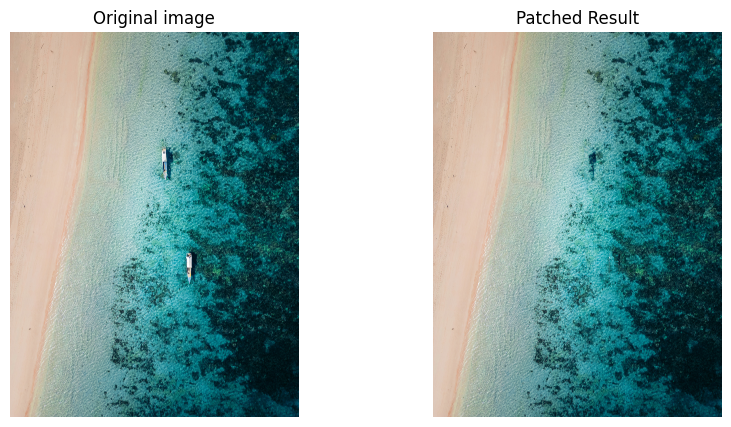

In [ ]:
original_image_bgr = cv2.imread('input\\patchmatch-input.jpg')
original_image_np = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)

x1, y1 = 3160, 2380
width1, height1 = 190, 750
x2, y2 = 3695, 4624
width2, height2 = 190, 650

image_with_hole_np = create_rectangular_hole(original_image_np, x1, y1, width1, height1)
image_with_hole_np = create_rectangular_hole(image_with_hole_np, x2, y2, width2, height2)

mask = np.zeros_like(image_with_hole_np[:,:,0])
mask[y1:y1+height1, x1:x1+width1] = 255
mask[y2:y2+height2, x2:x2+width2] = 255
result = perform_patch_match(
    image_with_hole_np,
    mask,
    patch_size=15,
    iterations=20,
    search_window=400
)
cv2.imwrite("output-patchmatch.jpg", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(original_image_np)
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Patched Result")
plt.imshow(result)
plt.axis('off')

plt.show()

## Section 3: Removing Objects and Completing the Image

For the last part, we will use above functions to remove the detected objects from section 1 and complete the initial image.

First, Remove the matched objects from `input.jpg` and plot the result. You may do this by simply setting the intensity of the matched pixels to 0 (or anything else).

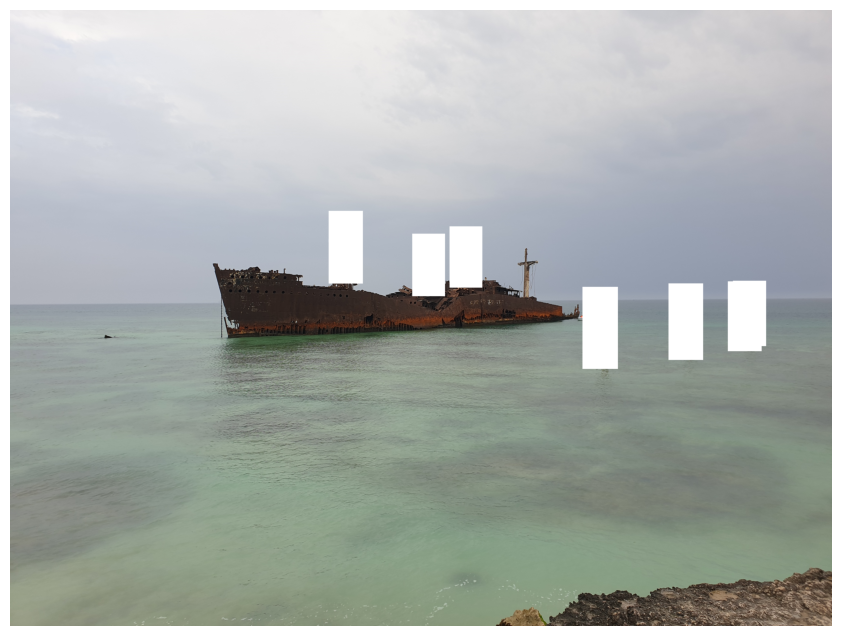

In [ ]:
img_patchmatch = cv2.imread('input\\input.jpg')
template_pathcmatch = np.array(crop_border('input\\template.png'))
img_gray_patchmatch = cv2.cvtColor(img_patchmatch, cv2.COLOR_BGR2GRAY)
template_gray_patchmatch = cv2.cvtColor(template_pathcmatch, cv2.COLOR_BGR2GRAY)

scales = np.linspace(0.4, 1.0, 10)

all_detections_patchmatch = find_template(img_gray_patchmatch, template_gray_patchmatch, scales)

final_threshold = 0.60
output_image_patchmatch = draw_bars(img_patchmatch.copy(), all_detections_patchmatch, final_threshold=final_threshold,fill=True)
plt.figure(figsize=(12, 8))
output_image_patchmatch=cv2.cvtColor(output_image_patchmatch, cv2.COLOR_BGR2RGB)
plt.imshow(output_image_patchmatch)
plt.axis('off')
plt.show()


Now, apply texture synthesis or patch match (or both) to complete the removed part of the image. Save the result as `output-complete.jpg`. Your score on this part depends on the qulity of the completed parts.

Overall Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1:   0%|          | 0/6230 [00:00<?, ?it/s]

Iteration 2:   0%|          | 0/6449 [00:00<?, ?it/s]

Iteration 3:   0%|          | 0/6425 [00:00<?, ?it/s]

Iteration 4:   0%|          | 0/6337 [00:00<?, ?it/s]

Iteration 5:   0%|          | 0/6217 [00:00<?, ?it/s]

Iteration 6:   0%|          | 0/6119 [00:00<?, ?it/s]

Iteration 7:   0%|          | 0/5958 [00:00<?, ?it/s]

Iteration 8:   0%|          | 0/5800 [00:00<?, ?it/s]

Iteration 9:   0%|          | 0/5696 [00:00<?, ?it/s]

Iteration 10:   0%|          | 0/5551 [00:00<?, ?it/s]

Iteration 11:   0%|          | 0/5460 [00:00<?, ?it/s]

Iteration 12:   0%|          | 0/5302 [00:00<?, ?it/s]

Iteration 13:   0%|          | 0/5124 [00:00<?, ?it/s]

Iteration 14:   0%|          | 0/4999 [00:00<?, ?it/s]

Iteration 15:   0%|          | 0/4821 [00:00<?, ?it/s]

Iteration 16:   0%|          | 0/4701 [00:00<?, ?it/s]

Iteration 17:   0%|          | 0/4594 [00:00<?, ?it/s]

Iteration 18:   0%|          | 0/4443 [00:00<?, ?it/s]

Iteration 19:   0%|          | 0/4296 [00:00<?, ?it/s]

Iteration 20:   0%|          | 0/4145 [00:00<?, ?it/s]

Iteration 21:   0%|          | 0/3978 [00:00<?, ?it/s]

Iteration 22:   0%|          | 0/3851 [00:00<?, ?it/s]

Iteration 23:   0%|          | 0/3704 [00:00<?, ?it/s]

Iteration 24:   0%|          | 0/3529 [00:00<?, ?it/s]

Iteration 25:   0%|          | 0/3421 [00:00<?, ?it/s]

Iteration 26:   0%|          | 0/3270 [00:00<?, ?it/s]

Iteration 27:   0%|          | 0/3025 [00:00<?, ?it/s]

Iteration 28:   0%|          | 0/2413 [00:00<?, ?it/s]

Iteration 29:   0%|          | 0/1837 [00:00<?, ?it/s]

Iteration 30:   0%|          | 0/1008 [00:00<?, ?it/s]

Iteration 31:   0%|          | 0/730 [00:00<?, ?it/s]

Iteration 32:   0%|          | 0/621 [00:00<?, ?it/s]

Iteration 33:   0%|          | 0/198 [00:00<?, ?it/s]

Iteration 34:   0%|          | 0/102 [00:00<?, ?it/s]

Iteration 35:   0%|          | 0/53 [00:00<?, ?it/s]

Iteration 36:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration 37: 0it [00:00, ?it/s]

Iteration 38: 0it [00:00, ?it/s]

Iteration 39: 0it [00:00, ?it/s]

Iteration 40: 0it [00:00, ?it/s]

Iteration 41: 0it [00:00, ?it/s]

Iteration 42: 0it [00:00, ?it/s]

Iteration 43: 0it [00:00, ?it/s]

Iteration 44: 0it [00:00, ?it/s]

Iteration 45: 0it [00:00, ?it/s]

Iteration 46: 0it [00:00, ?it/s]

Iteration 47: 0it [00:00, ?it/s]

Iteration 48: 0it [00:00, ?it/s]

Iteration 49: 0it [00:00, ?it/s]

Iteration 50: 0it [00:00, ?it/s]

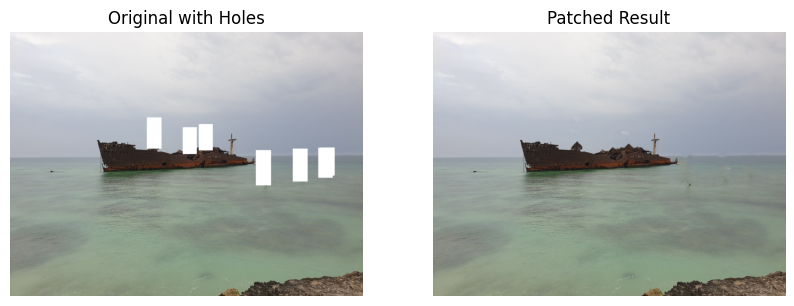

True

In [ ]:
def extract_mask_from_image(image_with_holes):
    white_pixels = np.all(image_with_holes == [255, 255, 255], axis=2)
    mask = np.zeros(image_with_holes.shape[:2], dtype=np.uint8)
    mask[white_pixels] = 255
    return mask

mask = extract_mask_from_image(output_image_patchmatch)
result = perform_patch_match(
    output_image_patchmatch,
    mask,
    patch_size=6,
    iterations=50,
    search_window=400
)

cv2.imwrite("output\\output-complete.jpg", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original with Holes")
plt.imshow(output_image_patchmatch)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Patched Result")
plt.imshow(result)
plt.axis('off')

plt.show()